In [117]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Parts we added
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report
import pandas as pd

Let us first read the train and test files

In [3]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

We create a SIFT object detector and descriptor

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

## We created functions to get descriptors and calculate Dense SIFT

In [83]:
def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]

def get_descriptors(dense=True, feat_num=250, step_size=20, mode="train"):
    
    descriptors = []
    label_per_descriptor = []
    
    if mode == "train":        
        img_filenames = train_images_filenames
        lbl_filenames = train_labels
        
    else:
        img_filenames = test_images_filenames
        lbl_filenames = test_labels
        
    Detector = cv2.SIFT_create(feat_num)

    for filename,labels in zip(img_filenames, lbl_filenames):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        
        if not dense:
            kpt, des=Detector.detectAndCompute(gray,None)
            
        else:
            kpt = create_dense_kp(gray.shape, step_size=step_size)                              
            _, des = Detector.compute(gray, kpt)
            
        descriptors.append(des)
        label_per_descriptor.append(labels)
    
    return descriptors, label_per_descriptor

<h5> First we get descriptors for each image, then we find visual words by clustering the descriptors. Therefore, what we do is to find a vocabulary from descriptors. After that, we find visual words for each image by putting its descriptors to k-means. Clusters of k-means correspond to words and each descriptor gets a word. </h5>

We now compute a k-means clustering on the descriptor space

## This function is used to find visual words

In [5]:
def get_visual_words(descriptors, k=128):
    
    D = np.vstack(descriptors)
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k*20, compute_labels=False,
                               reassignment_ratio=10**-4, random_state=42)
    codebook.fit(D)
    
    visual_words=np.zeros((len(descriptors), k),dtype=np.float32)
    
    for i in range(len(descriptors)):
        words=codebook.predict(descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
        
    return codebook, visual_words

## Hyperparameter search for SIFT and KNN

We tried different amount of local features, codebook sizes, distance metrics and n_neighbors.

In [60]:
knn_res_df = pd.DataFrame(columns=["n_features", "codebook_size", "n_neighbors","dist_metric",
                                   "mean_train_acc", "mean_test_acc", "mean_train_f1", "mean_test_f1"])

params = {
    "n_features": np.arange(200, 800, 100),
    #"dense": [True, False],
    #"step_size": np.arange(10, 60, 10),
    "codebook_size": np.arange(32, 256, 32),
    "n_neighbors": np.arange(3, 9, 1),
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]
}

for n in params["n_features"]:
    Train_descriptors, train_labels = get_descriptors(dense=False, feat_num=n)
    #Test_descriptors, test_labels = get_descriptors(False, n, ss, mode="test")

    for cs in params["codebook_size"]:
        codebook, visual_words = get_visual_words(Train_descriptors, cs)

        ##visual_words_test=np.zeros((len(test_labels),cs), dtype=np.float32)
        ##for i in range(len(Test_descriptors)):
        ##    words = codebook.predict(Test_descriptors[i])
        ##    visual_words_test[i,:] = np.bincount(words, minlength=cs)

        print(n, cs)

        knn = KNeighborsClassifier(n_jobs=-1)
        knn_grid = GridSearchCV(knn, {k:params[k] for k in ("n_neighbors", "metric") if k in params}, cv=8,
                                scoring=["accuracy", "f1_macro"], refit="accuracy", return_train_score=True)
        knn_grid.fit(visual_words, train_labels) 

        #test_preds = knn_grid.predict(visual_words_test)
        #print(f1_score(test_labels, test_preds, average="micro"))
        print("Finished this iteration!")
        best_acc = np.argmin(knn_grid.cv_results_["rank_test_accuracy"])
        knn_res_df = knn_res_df.append({
            "n_features": n,
            "codebook_size": cs,
            "n_neighbors": knn_grid.best_params_["n_neighbors"],
            "dist_metric": knn_grid.best_params_["metric"],
            "mean_train_acc": knn_grid.cv_results_["mean_train_accuracy"][best_acc], 
            "mean_test_acc": knn_grid.cv_results_["mean_test_accuracy"][best_acc], 
            "mean_train_f1": knn_grid.cv_results_["mean_train_f1_macro"][best_acc], 
            "mean_test_f1": knn_grid.cv_results_["mean_test_f1_macro"][best_acc]
        }, ignore_index=True)
        
knn_res_df.to_csv("knn_hp_results.csv", index=False)

200 32
Finished this iteration!
200 64
Finished this iteration!
200 96
Finished this iteration!
200 128
Finished this iteration!
200 160
Finished this iteration!
200 192
Finished this iteration!
200 224
Finished this iteration!
300 32
Finished this iteration!
300 64
Finished this iteration!
300 96
Finished this iteration!
300 128
Finished this iteration!
300 160
Finished this iteration!
300 192
Finished this iteration!
300 224
Finished this iteration!
400 32
Finished this iteration!
400 64
Finished this iteration!
400 96
Finished this iteration!
400 128
Finished this iteration!
400 160
Finished this iteration!
400 192
Finished this iteration!
400 224
Finished this iteration!
500 32
Finished this iteration!
500 64
Finished this iteration!
500 96
Finished this iteration!
500 128
Finished this iteration!
500 160
Finished this iteration!
500 192
Finished this iteration!
500 224
Finished this iteration!
600 32
Finished this iteration!
600 64
Finished this iteration!
600 96
Finished this ite

<AxesSubplot:xlabel='n_features'>

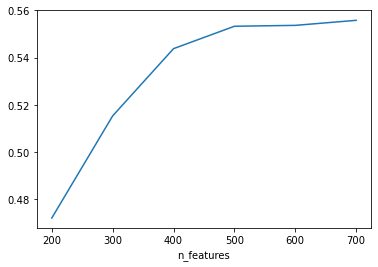

In [207]:
knn_res_df.groupby("n_features").mean()["mean_test_acc"].plot()

<AxesSubplot:xlabel='codebook_size'>

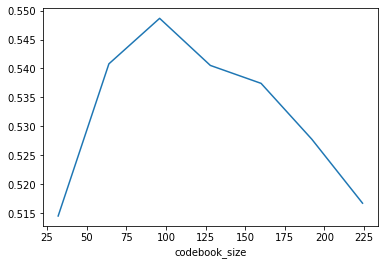

In [208]:
knn_res_df.groupby("codebook_size").mean()["mean_test_acc"].plot()

<AxesSubplot:xlabel='n_neighbors'>

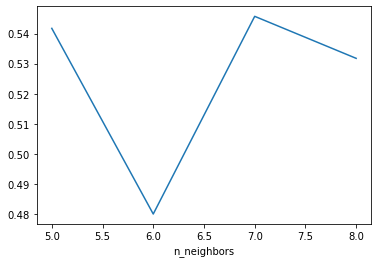

In [209]:
knn_res_df.groupby("n_neighbors").mean()["mean_test_acc"].plot()

In [199]:
knn_res_df.sort_values("mean_test_acc", ascending=False)

,n_features,codebook_size,n_neighbors,dist_metric,mean_train_acc,mean_test_acc,mean_train_f1,mean_test_f1
23,500,96,8,euclidean,0.684287,0.577385,0.682785,0.572716
29,600,64,7,euclidean,0.679654,0.571545,0.679639,0.566451
38,700,128,7,euclidean,0.681780,0.566221,0.681430,0.560637
16,400,96,8,euclidean,0.676920,0.566212,0.673437,0.557914
36,700,64,8,euclidean,0.679730,0.565157,0.680429,0.560943
24,500,128,8,euclidean,0.667729,0.561411,0.665346,0.552304
25,500,160,7,euclidean,0.668263,0.560916,0.668721,0.559370
37,700,96,8,euclidean,0.664692,0.559306,0.664418,0.555538
39,700,160,8,euclidean,0.667579,0.558774,0.665661,0.551355
31,600,128,8,euclidean,0.667199,0.558249,0.667474,0.554423


## Hyperparameter search for Dense-SIFT and KNN

In [88]:
knn_dSIFT_res_df = pd.DataFrame(columns=["step_size", "codebook_size", "n_neighbors","dist_metric",
                                   "mean_train_acc", "mean_test_acc", "mean_train_f1", "mean_test_f1"])

params = {
    #"dense": [True, False],
    "step_size": np.arange(10, 60, 10),
    "codebook_size": np.arange(64, 256, 32),
    "n_neighbors": np.arange(6, 9, 1),
    "metric": ["euclidean", "manhattan"]
}

for ss in params["step_size"]:
    Train_descriptors, train_labels = get_descriptors(feat_num=500, step_size=int(ss))
    #Test_descriptors, test_labels = get_descriptors(False, n, ss, mode="test")

    for cs in params["codebook_size"]:
        codebook, visual_words = get_visual_words(Train_descriptors, cs)

        ##visual_words_test=np.zeros((len(test_labels),cs), dtype=np.float32)
        ##for i in range(len(Test_descriptors)):
        ##    words = codebook.predict(Test_descriptors[i])
        ##    visual_words_test[i,:] = np.bincount(words, minlength=cs)

        print(ss, cs)

        knn = KNeighborsClassifier(n_jobs=-1)
        knn_grid = GridSearchCV(knn, {k:params[k] for k in ("n_neighbors", "metric") if k in params}, cv=8,
                                scoring=["accuracy", "f1_macro"], refit="accuracy", return_train_score=True)
        knn_grid.fit(visual_words, train_labels) 

        #test_preds = knn_grid.predict(visual_words_test)
        #print(f1_score(test_labels, test_preds, average="micro"))
        print("Finished this iteration!")
        best_acc = np.argmin(knn_grid.cv_results_["rank_test_accuracy"])
        knn_dSIFT_res_df = knn_dSIFT_res_df.append({
            "step_size": ss,
            "codebook_size": cs,
            "n_neighbors": knn_grid.best_params_["n_neighbors"],
            "dist_metric": knn_grid.best_params_["metric"],
            "mean_train_acc": knn_grid.cv_results_["mean_train_accuracy"][best_acc], 
            "mean_test_acc": knn_grid.cv_results_["mean_test_accuracy"][best_acc], 
            "mean_train_f1": knn_grid.cv_results_["mean_train_f1_macro"][best_acc], 
            "mean_test_f1": knn_grid.cv_results_["mean_test_f1_macro"][best_acc]
        }, ignore_index=True)
        
knn_dSIFT_res_df.to_csv("knn_dSIFT_res.csv", index=False)

10 64
Finished this iteration!
10 96
Finished this iteration!
10 128
Finished this iteration!
10 160
Finished this iteration!
10 192
Finished this iteration!
10 224
Finished this iteration!
20 64
Finished this iteration!
20 96
Finished this iteration!
20 128
Finished this iteration!
20 160
Finished this iteration!
20 192
Finished this iteration!
20 224
Finished this iteration!
30 64
Finished this iteration!
30 96
Finished this iteration!
30 128
Finished this iteration!
30 160
Finished this iteration!
30 192
Finished this iteration!
30 224
Finished this iteration!
40 64
Finished this iteration!
40 96
Finished this iteration!
40 128
Finished this iteration!
40 160
Finished this iteration!
40 192
Finished this iteration!
40 224
Finished this iteration!
50 64
Finished this iteration!
50 96
Finished this iteration!
50 128
Finished this iteration!
50 160
Finished this iteration!
50 192
Finished this iteration!
50 224
Finished this iteration!


<AxesSubplot:xlabel='step_size'>

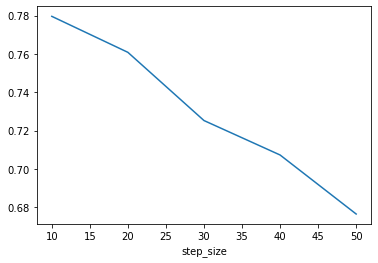

In [212]:
knn_dSIFT_res_df.groupby("step_size").mean()["mean_test_acc"].plot()

In [92]:
knn_dSIFT_res_df.sort_values("mean_test_acc", ascending=False)

,step_size,codebook_size,n_neighbors,dist_metric,mean_train_acc,mean_test_acc,mean_train_f1,mean_test_f1
5,10,224,8,manhattan,0.840586,0.791077,0.842353,0.789539
3,10,160,8,manhattan,0.840663,0.788970,0.842648,0.788675
4,10,192,8,manhattan,0.845522,0.787365,0.848156,0.788182
2,10,128,8,manhattan,0.839143,0.779386,0.839845,0.776905
1,10,96,6,manhattan,0.840359,0.773014,0.842802,0.774159
9,20,160,8,manhattan,0.824257,0.772469,0.827292,0.774697
11,20,224,8,manhattan,0.827295,0.770875,0.830569,0.773079
10,20,192,8,manhattan,0.821751,0.769818,0.825063,0.770456
7,20,96,7,manhattan,0.817346,0.760224,0.820296,0.762726
0,10,64,8,manhattan,0.815448,0.758118,0.816535,0.758240


In [193]:
Train_descriptors, train_labels = get_descriptors(feat_num=500, step_size=10)
codebook, visual_words = get_visual_words(Train_descriptors, 224)

visual_words_test=np.zeros((len(test_labels),224), dtype=np.float32)
for i in range(len(Test_descriptors)):
    words = codebook.predict(Test_descriptors[i])
    visual_words_test[i,:] = np.bincount(words, minlength=224)
    

params = {
    "C": np.arange(0.0001, 1, 0.01),
    "max_iter": np.arange(50, 550, 50)
}
    
lg = LogisticRegression(solver='liblinear')

lg_grid = GridSearchCV(lg, params, cv=8,
                        scoring=["accuracy", "f1_macro"], refit="accuracy", return_train_score=True)
lg_grid.fit(visual_words, train_labels) 

best_acc = np.argmin(lg_grid.cv_results_["rank_test_accuracy"])

In [196]:
lg_grid.cv_results_["params"][best_acc]

{'C': 0.0001, 'max_iter': 50}

In [197]:
lg = LogisticRegression(C=0.0001, max_iter=50, solver='liblinear')

train_labels = pd.Categorical(train_labels).codes
test_labels = pd.Categorical(test_labels).codes

lg.fit(visual_words, train_labels)
train_preds = lg.predict(visual_words)
test_preds = lg.predict(visual_words_test)

print(classification_report(train_labels, train_preds))
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       292
           1       0.81      0.86      0.83       244
           2       0.89      0.95      0.92       227
           3       0.92      0.80      0.86       184
           4       0.90      0.86      0.88       214
           5       0.83      0.87      0.85       260
           6       0.91      0.85      0.88       212
           7       0.91      0.94      0.92       248

    accuracy                           0.87      1881
   macro avg       0.87      0.87      0.87      1881
weighted avg       0.87      0.87      0.87      1881

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       118
           1       0.79      0.83      0.81       116
           2       0.86      0.94      0.90       101
           3       0.88      0.76      0.82        76
           4       0.83      0.83      0.83        94
           5       0.78 

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

We build a k-nn classifier and train it with the train descriptors

We end up computing the test descriptors and compute the accuracy of the model

Dimensionality reduction, with PCA and LDA

In [ ]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)